In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from urllib.parse import urlparse
import tldextract
%matplotlib inline
import random
import gc
from sklearn.tree import DecisionTreeClassifier

In [2]:
df=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_1.csv")
df2=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_2.csv")
df3=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_3.csv")

In [3]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
df2.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [5]:
df3.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [7]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  450176 non-null  int64 
 1   url         450176 non-null  object
 2   label       450176 non-null  object
 3   result      450176 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.7+ MB


In [9]:
df2.describe()

,Unnamed: 0,result
count,450176.000000,450176.000000
mean,225087.500000,0.231994
std,129954.761728,0.422105
min,0.000000,0.000000
25%,112543.750000,0.000000
50%,225087.500000,0.000000
75%,337631.250000,0.000000
max,450175.000000,1.000000


In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [11]:
df3.describe()

,url,label
count,420464,420464
unique,411247,2
top,d11m2p9mpffp32.cloudfront.net/main/web_zt.exe,good
freq,27,344821


Preprocessing the data

In [12]:
df['type']=df['type'].replace({'phishing':1,'benign':0,'defacement':1,'malware':1})

In [13]:
df2.drop(df2.columns[df2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df2.drop('label',axis = 1, inplace = True)
df2=df2.rename(columns={'result': 'type'})

In [14]:
df3=df3.rename(columns={'label': 'type'})
df3['type']=df3['type'].replace({'bad':1,'good':0})

In [15]:
df=df.append(df2)
df=df.append(df3)

In [16]:
df.drop_duplicates(keep='first',inplace=True)

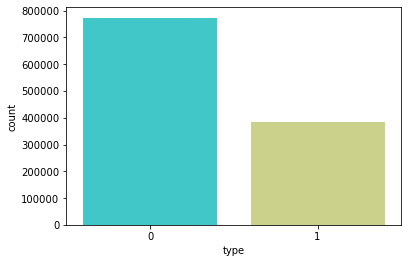

In [17]:
sns.countplot(x='type',data=df, palette='rainbow')
plt.show()

In [18]:
#cleaner method
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    #if 'com' in allTokens:
        #allTokens.remove('com')
    return allTokens

In [19]:
#Feature Extraction methods

#returns the length of the url
def http(s):
    return s.count('http')

#returns the count of http in the url
def https(s):
    return s.count('https')

#returns the count of www in the url
def www(s):
    return s.count('www')

#returns the count of digits in the url
def digit(s):
    return sum(i.isnumeric() for i in s)

#returns the count of alphabets in the url
def alpha(s):
    return sum(i.isalpha() for i in s)

#returns the count of special character's in the url
def spec_char(s):
    return sum((not(i.isalpha()) and not(i.isnumeric())) for i in s)

#returns the count of / in the url
def spec_char_1(s):
    return s.count('/')

#returns the count of ! in the url
def spec_char_2(s):
    return s.count('!')

#returns the count of . in the url
def spec_char_3(s):
    return s.count('.')

#returns the count of @ in the url    
def spec_char_4(s):
    return s.count('@')

#returns the count of % in the url
def spec_char_5(s):
    return s.count('%')

#returns the count of ? in the url
def spec_char_6(s):
    return s.count('?')

#returns the count of = in the url
def spec_char_7(s):
    return s.count('=')

#returns the count of + in the url
def spec_char_8(s):
    return s.count('+')

#returns the count of - in the url
def spec_char_9(s):
    return s.count('-')

#returns the count of & in the url
def spec_char_10(s):
    return s.count('&')

def query_length(s):
    return len(urlparse(s).query)

#returns the domain of the url
def dom_suffix(s):
    domains={'com':1,'edu':2,'org':3,'net':4,'onion':5,'in':6}
    s=tldextract.extract(s).suffix
    if s in domains.keys():
        return domains[s]
    else:
        return 0

#returns the length of the domain
def dom_length(s):
    return len(tldextract.extract(s).domain)


#returns the length of the sub_domain
def subdom_length(s):
    return len(tldextract.extract(s).subdomain)

#returns the length of the url path
def path_length(s):
    return len(urlparse(s).path)

#returns 1 if url contains a query
def has_query(s):
    if len(urlparse(s).query)==0:
        return 0
    else:
        return 1

def ip(s):
    has_ip=re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
    '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
    '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
    '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', s)
    if has_ip:
        return 1
    else:
        return 0

#.php .EXE .html .htm .txt .avi .jar .js
def extension(s):
    domains={'.htm':1,'.html':2,'.js':3,'.css':4,'.exe':5,}
    if s in domains.keys():
        return domains[s]
        
#remove youtube links -- youtube.com/watch
#Special characters , * _ / ? .

In [20]:
#Extracting the feautures
df['len']=df['url'].apply(lambda s : len(str(s)))
df['http_count']=df['url'].apply(lambda s : http(s))
df['https_count']=df['url'].apply(lambda s : https(s))
df['www']=df['url'].apply(lambda s : www(s))
df['digit_count']=df['url'].apply(lambda s: digit(s))
df['alpha_count']=df['url'].apply(lambda s: alpha(s))
df['spec_char_count']=df['url'].apply(lambda s: spec_char(s))
df['/']=df['url'].apply(lambda s: spec_char_1(s))
df['!']=df['url'].apply(lambda s: spec_char_2(s))
df['.']=df['url'].apply(lambda s: spec_char_3(s))
df['@']=df['url'].apply(lambda s: spec_char_4(s))
df['%']=df['url'].apply(lambda s: spec_char_5(s))
df['?']=df['url'].apply(lambda s: spec_char_6(s))
df['=']=df['url'].apply(lambda s: spec_char_7(s))
df['+']=df['url'].apply(lambda s: spec_char_8(s))
df['-']=df['url'].apply(lambda s: spec_char_9(s))
df['dom_suffix']=df['url'].apply(lambda s: dom_suffix(s))
df['dom_length']=df['url'].apply(lambda s: dom_length(s))
df['subdom_length']=df['url'].apply(lambda s: subdom_length(s))
df['query']=df['url'].apply(lambda s: has_query(s))
#df['extension']=df['url'].apply(lambda s: extension(s))
df['ip']=df['url'].apply(lambda s: ip(s))

In [21]:
df = shuffle(df)

In [22]:
df.head()

,url,type,len,http_count,https_count,www,digit_count,alpha_count,spec_char_count,/,...,%,?,=,+,-,dom_suffix,dom_length,subdom_length,query,ip
37734,https://www.en.wikipedia.org/wiki/Olivar_Asselin,0,48,1,1,1,0,39,9,4,...,0,0,0,0,0,3,9,6,0,0
180843,http://www.gerridavis.com/gerris-links,1,38,1,0,1,0,31,7,3,...,0,0,0,0,1,1,10,3,0,0
216848,en.wikipedia.org/wiki/Joe_Bravo_(jockey),0,40,0,0,0,0,32,8,2,...,0,0,0,0,0,3,9,2,0,0
385180,http://odihost.com/hypno/mail/index.php,1,39,1,0,0,0,31,8,5,...,0,0,0,0,0,1,7,0,0,0
172843,https://www.dfamilk.com/,0,24,1,1,1,0,18,6,3,...,0,0,0,0,0,1,7,3,0,0


In [23]:
# vectorised_url=TfidfVectorizer(tokenizer=getTokens)
# df['vector']=vectorised_url.fit_transform(df['url'])

In [24]:
#df = df.reset_index()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156638 entries, 37734 to 312800
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   url              1156638 non-null  object
 1   type             1156638 non-null  int64 
 2   len              1156638 non-null  int64 
 3   http_count       1156638 non-null  int64 
 4   https_count      1156638 non-null  int64 
 5   www              1156638 non-null  int64 
 6   digit_count      1156638 non-null  int64 
 7   alpha_count      1156638 non-null  int64 
 8   spec_char_count  1156638 non-null  int64 
 9   /                1156638 non-null  int64 
 10  !                1156638 non-null  int64 
 11  .                1156638 non-null  int64 
 12  @                1156638 non-null  int64 
 13  %                1156638 non-null  int64 
 14  ?                1156638 non-null  int64 
 15  =                1156638 non-null  int64 
 16  +                1156638 non-null

In [32]:
x=df[['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','ip']]
y=df['type']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True')

In [34]:
model=LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

In [35]:
model.score(x_test,y_test)

0.8557545995296721

In [37]:
pred=model.predict(x_test)

In [38]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[150526   4424]
 [ 28944  47434]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    154950
           1       0.91      0.62      0.74     76378

    accuracy                           0.86    231328
   macro avg       0.88      0.80      0.82    231328
weighted avg       0.86      0.86      0.85    231328

